# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as VF

import torchvision
from torchvision import datasets, transforms

# Load MNIST datasets

## Add custom transform class to add Gaussian Noise

In [2]:
# Custom transform class to en-noise image data
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        noisy = tensor + torch.normal(mean=self.mean, std=self.std, size=tensor.size())
        noisy = torch.clamp(noisy, 0.0, 0.5)
        return (noisy, tensor)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

# Utility function to visualize image batches in grids
def show(imgs, title=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
    fig.suptitle(title)
    plt.show()

## Load MNIST datasets

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.8)
])

mnist_data = torchvision.datasets.MNIST(
    '/tmp/mnist', 
    download=True, 
    train=True, 
    transform=transform
)

loader = torch.utils.data.DataLoader(
    mnist_data,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw


0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Visualize noisy and normal samples

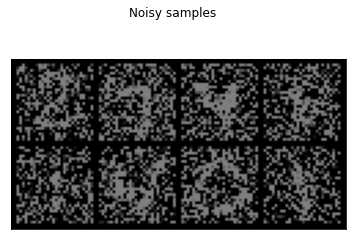

In [4]:
(images, normal), labels = next(iter(loader))
grid = torchvision.utils.make_grid(images, nrow=4, pad_value=0)
show(grid, title='Noisy samples')

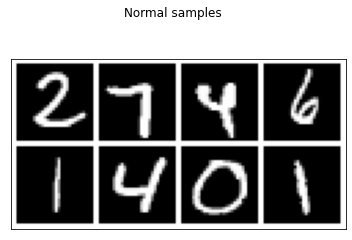

In [5]:
grid = torchvision.utils.make_grid(normal, nrow=4, pad_value=1)
show(grid, title='Normal samples')

# Define the network architecture

In [6]:
class ISTA_Module(nn.Module):
    def __init__(self, input_dim):
        super(ISTA_Module, self).__init__()
        self._lambda = nn.Parameter(data=torch.normal(size=(1,), std=1.0, mean=0.0))
        self.linear1 = nn.Linear(in_features=input_dim, out_features=input_dim)
        self.linear2 = nn.Linear(in_features=input_dim, out_features=input_dim)
        
    def soft_thresholding(self, x):
        return torch.sign(x) * F.relu(torch.abs(x) - self._lambda)
    
    def forward(self, x, y):
        outputs = self.soft_thresholding(self.linear1(x) + self.linear2(y))
        
        return outputs
    
class LISTA(nn.Module):
    def __init__(self, input_dim, L=10):
        super(LISTA, self).__init__()
        self.input_dim = input_dim
        self.L = L
    
        self.ista_modules = nn.ModuleList()
        
        for i in range(self.L):
            self.ista_modules.append(ISTA_Module(input_dim=self.input_dim))
        
    def forward(self, y):
        x = torch.zeros_like(y)
        
        for layer in self.ista_modules:
            x = layer(x, y)
            
        return x
    
class DenoiseNetwork(nn.Module):
    def __init__(self, input_dim, num_layers=3):
        super(DenoiseNetwork, self).__init__()
        self.num_layers = num_layers
        self.batchnorms = nn.ModuleList()
        self.layers = nn.ModuleList()
        
        for i in range(self.num_layers):
            self.layers.append(nn.Linear(in_features=input_dim, out_features=input_dim))
            self.layers.append(nn.BatchNorm1d(input_dim))
            
    def forward(self, x):
        outputs = x
        
        for norm, layer in zip(self.batchnorms, self.layers):
            x = layer(x)
            x = F.relu(x)
            x = norm(x)
            
        outputs = F.sigmoid(x)
        return outputs

In [7]:
(noisy, normal), labels = next(iter(loader))
noisy = torch.flatten(noisy, 1)
normal = torch.flatten(normal, 1)

input_dim = noisy.shape[1]

# Define a LISTA for sparse representation learning and a simple network for denoising

In [19]:
def train_lista(train_loader, head_layers=1, L=3, norm=1, lambda_=1e-4, lr=0.0001, epochs=10):
    '''
    '''
    lista = LISTA(input_dim, L=L)
    network = DenoiseNetwork(input_dim, num_layers=head_layers)

    optimizer1 = optim.Adam(lista.parameters(), lr=lr)
    optimizer2 = optim.Adam(network.parameters(), lr=lr)
    criterion = nn.MSELoss()

    try:
        for i in range(epochs):
            for j, ((noisy, normal), labels) in enumerate(train_loader):  
                optimizer1.zero_grad()
                optimizer2.zero_grad()

                noisy = torch.flatten(noisy, 1)
                normal = torch.flatten(normal, 1)

                x = lista(noisy)
                reg = 0
                if(norm is not None):
                    reg = lambda_ * torch.mean(torch.norm(x, p=norm, dim=1))
                outputs = network(x)
                loss = criterion(outputs, normal) + reg

                if((j + 1) % 100 == 0):
                    print(f'[INFO] Epoch #[{i+1}/{epochs}], batch #[{j+1}/{len(loader)}], loss = {loss.item()}')

                loss.backward()

                optimizer1.step()
                optimizer2.step()
    except KeyboardInterrupt:
        print('[INFO] Training halted ... ')
        
    return lista, network

lista, network = train_lista(loader)

[INFO] Epoch #[1/10], batch #[99/7500], loss = 0.1971006989479065
[INFO] Epoch #[1/10], batch #[199/7500], loss = 0.19053643941879272
[INFO] Epoch #[1/10], batch #[299/7500], loss = 0.1928149163722992
[INFO] Epoch #[1/10], batch #[399/7500], loss = 0.18439999222755432
[INFO] Epoch #[1/10], batch #[499/7500], loss = 0.17903010547161102
[INFO] Epoch #[1/10], batch #[599/7500], loss = 0.17996883392333984
[INFO] Epoch #[1/10], batch #[699/7500], loss = 0.1711653769016266
[INFO] Training halted ... 


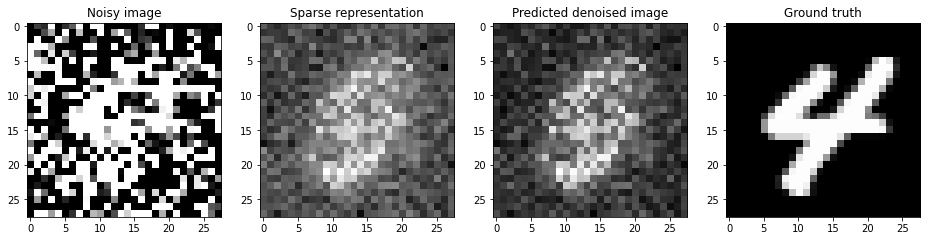

In [20]:
(noisy, normal), labels = next(iter(loader))
noisy = torch.flatten(noisy, 1)
normal = torch.flatten(normal, 1)

output = lista(noisy)
sparse_rep = output

output = network(output)

output = output.reshape(8, 28, 28)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].imshow(noisy.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')
ax[1].imshow(sparse_rep.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')
ax[2].imshow(output.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')
ax[3].imshow(normal.detach().numpy().reshape(-1, 28, 28)[1], cmap='gray')

ax[0].set_title('Noisy image')
ax[1].set_title('Sparse representation')
ax[2].set_title('Predicted denoised image')
ax[3].set_title('Ground truth')

plt.show()